In [2]:
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
from tqdm import tqdm, trange
from glob import glob 
import segmenteverygrain as seg
import os
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [37]:
from importlib import reload
reload(seg)

<module 'segmenteverygrain' from '/Users/zoltan/Dropbox/Segmentation/segmenteverygrain/segmenteverygrain/segmenteverygrain.py'>

## Create patches from large images

In [3]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/labels/'
dirname = '/Users/zoltan/Dropbox/Segmentation/images/'
images = sorted(glob(dirname + "*image*"))
labels = sorted(glob(dirname + "*mask*"))

start_no = 0
for image in tqdm(images):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 3])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,:]).astype('uint8')
        imname = image_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]
    
start_no = 0
for image in tqdm(labels):
    # Load the large image
    large_image = tf.keras.preprocessing.image.load_img(image)
    # Convert the image to a tensor
    large_image = tf.keras.preprocessing.image.img_to_array(large_image)
    large_image = large_image[:,:,0,np.newaxis] # only keep one layer and add a new axis
    # Reshape the tensor to have a batch size of 1
    large_image = tf.reshape(large_image, [1, *large_image.shape])
    # Extract patches from the large image
    patches = tf.image.extract_patches(
        images=large_image,
        sizes=[1, 256, 256, 1],
        strides=[1, 128, 128, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'
    )
    # Reshape the patches tensor to have a batch size of -1
    patches = tf.reshape(patches, [-1, 256, 256, 1])
    # Write patches to files
    for i in range(patches.shape[0]):
        im = np.asarray(patches[i,:,:,0]).astype('uint8')
        imname = mask_dir + 'im%03d.png'%(start_no + i)
        im = Image.fromarray(im.astype(np.uint8))
        im.save(imname)
    start_no = start_no + patches.shape[0]

  0%|                                                                                                                                                                                                                               | 0/35 [00:00<?, ?it/s]2023-05-30 15:52:04.132862: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-30 15:52:04.133024: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Max


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 35/35 [06:50<00:00, 11.73s/it]


## Create training, validation, and test sets

In [5]:
image_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/images/'
mask_dir = '/Users/zoltan/Dropbox/Segmentation/Tiles/labels/'
image_files = sorted(glob(os.path.join(image_dir, '*.png')))
mask_files = sorted(glob(os.path.join(mask_dir, '*.png')))

batch_size = 32
shuffle_buffer_size = 1000

# split half into training
train_idx = np.random.choice(np.arange(len(image_files)), size = int(len(image_files)/2) , replace=False)
# get the rest
idx = np.setdiff1d(np.arange(len(image_files)), train_idx)
# get val files (25% of total)
val_idx = np.random.choice(idx, size = int(len(image_files)/4) , replace=False)
# get test files (25% of total)
test_idx = np.setdiff1d(val_idx, train_idx)

# create arrays of training, validation, and test files (these are filenames)
train_images = np.array(image_files)[train_idx]
val_images = np.array(image_files)[val_idx]
test_images = np.array(image_files)[test_idx]

train_masks = np.array(mask_files)[train_idx]
val_masks = np.array(mask_files)[val_idx]
test_masks = np.array(mask_files)[test_idx]

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_masks))
train_dataset = train_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_masks))
val_dataset = val_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_masks))
test_dataset = test_dataset.map(seg.load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)

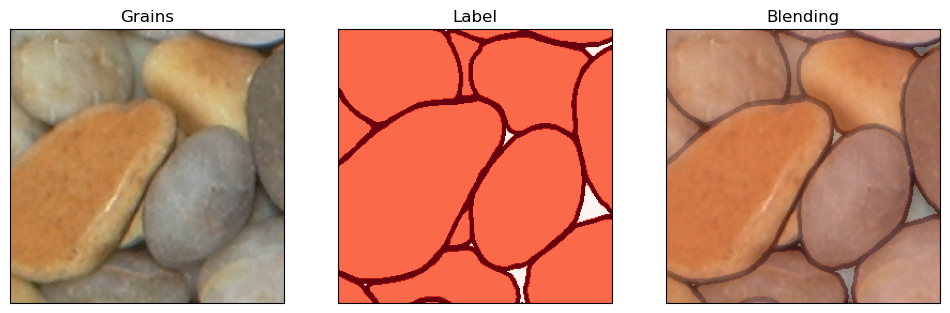

In [44]:
# check how masks look like
fname = train_images[1000]
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # need to convert from BGR to RGB
mask = cv2.imread(fname.replace('images', 'labels'))
seg.plot_images_and_labels(img, mask)

## Build, train, and evaluate model

In [38]:
model = seg.Unet()
model.compile(optimizer=Adam(), loss=seg.weighted_crossentropy, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  2320        ['conv2d[0][0]']                 
                                )                                                             

 concatenate_2 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_2[0][0]',     
                                )                                 'batch_normalization_1[0][0]']  
                                                                                                  
 conv2d_14 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_2[0][0]']          
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 128, 128, 32  9248        ['conv2d_14[0][0]']              
                                )                                                                 
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 128, 128, 32  128        ['conv2d_15[0][0]']              
 rmalizati

In [39]:
history = model.fit(train_dataset, epochs=200, validation_data=val_dataset)

Epoch 1/200


2023-05-31 02:29:53.373887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


177/177 [==============================] - ETA: 0s - loss: 0.9075 - accuracy: 0.7151

2023-05-31 02:30:22.221120: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


177/177 [==============================] - 35s 182ms/step - loss: 0.9075 - accuracy: 0.7151 - val_loss: 1.1659 - val_accuracy: 0.5778
Epoch 2/200
177/177 [==============================] - 31s 174ms/step - loss: 0.8122 - accuracy: 0.8196 - val_loss: 0.9704 - val_accuracy: 0.7524
Epoch 3/200
177/177 [==============================] - 31s 173ms/step - loss: 0.7884 - accuracy: 0.8455 - val_loss: 0.7981 - val_accuracy: 0.8444
Epoch 4/200
177/177 [==============================] - 31s 176ms/step - loss: 0.7752 - accuracy: 0.8597 - val_loss: 0.8083 - val_accuracy: 0.8174
Epoch 5/200
177/177 [==============================] - 31s 176ms/step - loss: 0.7596 - accuracy: 0.8760 - val_loss: 0.7626 - val_accuracy: 0.8754
Epoch 6/200
177/177 [==============================] - 31s 176ms/step - loss: 0.7552 - accuracy: 0.8796 - val_loss: 0.7573 - val_accuracy: 0.8757
Epoch 7/200
177/177 [==============================] - 31s 173ms/step - loss: 0.7503 - accuracy: 0.8846 - val_loss: 0.7681 - val_accurac

Epoch 57/200
177/177 [==============================] - 31s 173ms/step - loss: 0.6749 - accuracy: 0.9538 - val_loss: 0.6951 - val_accuracy: 0.9450
Epoch 58/200
177/177 [==============================] - 31s 171ms/step - loss: 0.6676 - accuracy: 0.9608 - val_loss: 0.6931 - val_accuracy: 0.9479
Epoch 59/200
177/177 [==============================] - 31s 172ms/step - loss: 0.6647 - accuracy: 0.9635 - val_loss: 0.6933 - val_accuracy: 0.9475
Epoch 60/200
177/177 [==============================] - 31s 172ms/step - loss: 0.6624 - accuracy: 0.9657 - val_loss: 0.6921 - val_accuracy: 0.9492
Epoch 61/200
177/177 [==============================] - 31s 172ms/step - loss: 0.6615 - accuracy: 0.9664 - val_loss: 0.6954 - val_accuracy: 0.9497
Epoch 62/200
177/177 [==============================] - 31s 173ms/step - loss: 0.6616 - accuracy: 0.9663 - val_loss: 0.6973 - val_accuracy: 0.9489
Epoch 63/200
177/177 [==============================] - 31s 172ms/step - loss: 0.6608 - accuracy: 0.9672 - val_loss: 0

177/177 [==============================] - 30s 171ms/step - loss: 0.6526 - accuracy: 0.9747 - val_loss: 0.6953 - val_accuracy: 0.9514
Epoch 113/200
177/177 [==============================] - 30s 171ms/step - loss: 0.6519 - accuracy: 0.9755 - val_loss: 0.6906 - val_accuracy: 0.9531
Epoch 114/200
177/177 [==============================] - 31s 171ms/step - loss: 0.6537 - accuracy: 0.9737 - val_loss: 0.6883 - val_accuracy: 0.9585
Epoch 115/200
177/177 [==============================] - 31s 172ms/step - loss: 0.6505 - accuracy: 0.9768 - val_loss: 0.6877 - val_accuracy: 0.9581
Epoch 116/200
177/177 [==============================] - 31s 173ms/step - loss: 0.6494 - accuracy: 0.9778 - val_loss: 0.6871 - val_accuracy: 0.9583
Epoch 117/200
177/177 [==============================] - 31s 172ms/step - loss: 0.6492 - accuracy: 0.9780 - val_loss: 0.6876 - val_accuracy: 0.9594
Epoch 118/200
177/177 [==============================] - 31s 171ms/step - loss: 0.6501 - accuracy: 0.9770 - val_loss: 0.6887 -

177/177 [==============================] - 31s 172ms/step - loss: 0.6455 - accuracy: 0.9815 - val_loss: 0.6858 - val_accuracy: 0.9612
Epoch 168/200
177/177 [==============================] - 31s 172ms/step - loss: 0.6451 - accuracy: 0.9818 - val_loss: 0.6884 - val_accuracy: 0.9617
Epoch 169/200
177/177 [==============================] - 31s 172ms/step - loss: 0.6449 - accuracy: 0.9821 - val_loss: 0.6863 - val_accuracy: 0.9619
Epoch 170/200
177/177 [==============================] - 31s 173ms/step - loss: 0.6452 - accuracy: 0.9818 - val_loss: 0.6867 - val_accuracy: 0.9593
Epoch 171/200
177/177 [==============================] - 31s 172ms/step - loss: 0.6459 - accuracy: 0.9812 - val_loss: 0.6859 - val_accuracy: 0.9610
Epoch 172/200
177/177 [==============================] - 31s 173ms/step - loss: 0.6451 - accuracy: 0.9818 - val_loss: 0.6862 - val_accuracy: 0.9601
Epoch 173/200
177/177 [==============================] - 31s 173ms/step - loss: 0.6456 - accuracy: 0.9814 - val_loss: 0.6875 -

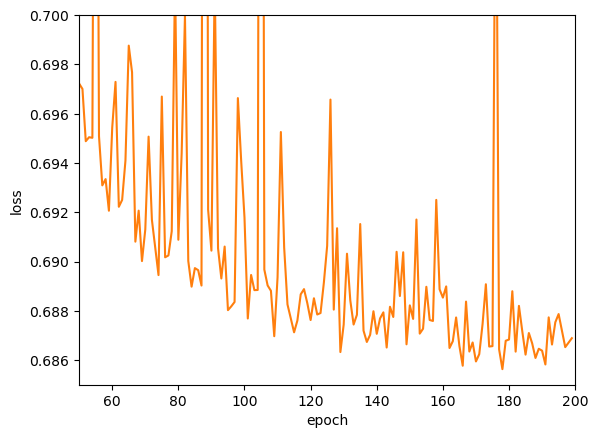

In [59]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss');
plt.xlim([50,200])
plt.ylim([0.685, 0.700]);

(0.95, 0.985)

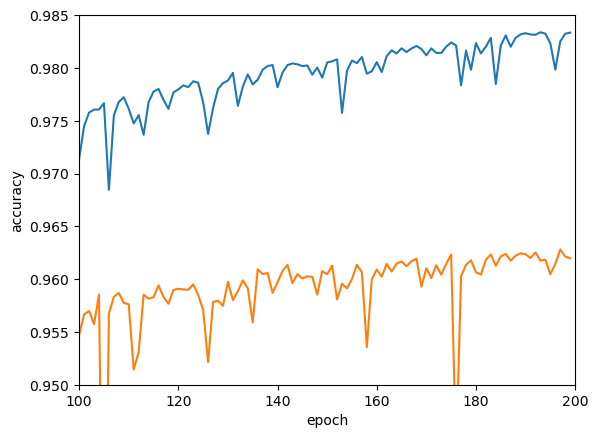

In [54]:
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.xlim([100,200])
plt.ylim([0.95, 0.985])

In [42]:
model.evaluate(test_dataset)

89/89 [==============================] - 5s 57ms/step - loss: 0.6869 - accuracy: 0.9620


[0.6868884563446045, 0.9619690775871277]

In [43]:
model.save_weights('seg_model')